In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from collections import deque

In [2]:
"""
for google colab support
"""

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/BA/Cure/4Colors'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Compare4ColorsCureipynb.ipynb', 'Cure4Color.ipynb', 'Cure4ColorMulStrats.ipynb', 'cities.csv', 'combined_SUM_Cure.csv', 'combined_SUM_Cure_Cure.csv', 'combined_SUM_DC_sum_Cure.csv', 'combined_SUM_DC_sum_Cure_Cure.csv', 'combined_SUM_DC_sum_repeat_Cure.csv', 'combined_SUM_DC_sum_repeat_Cure_Cure.csv', 'combined_SUM_repeat_Cure.csv', 'combined_SUM_repeat_Cure_Cure.csv', 'combined_repeat_Cure.csv', 'disease_counters.csv', 'disinfect_combined_mul_Cure.csv', 'disinfect_combined_mul_Cure_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_Cure_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_repeat_Cure.csv', 'disinfect_combined_mul_disease_counter_sum_repeat_Cure_Cure.csv', 'disinfect_combined_mul_repeat_Cure.csv', 'disinfect_combined_mul_repeat_Cure_Cure.csv', 'edges.csv', 'most_cubes_repeat_Cure.csv', 'node_positions.csv', 'random_Cure.csv']


In [3]:
# Load CSV files
cities_df = pd.read_csv('cities.csv', index_col='City')
disease_counters_df = pd.read_csv('disease_counters.csv', index_col='City')
edges_df = pd.read_csv('edges.csv')
positions_df = pd.read_csv('node_positions.csv', index_col='City')

In [4]:
colors = ['yellow', 'blue', 'black', 'red']

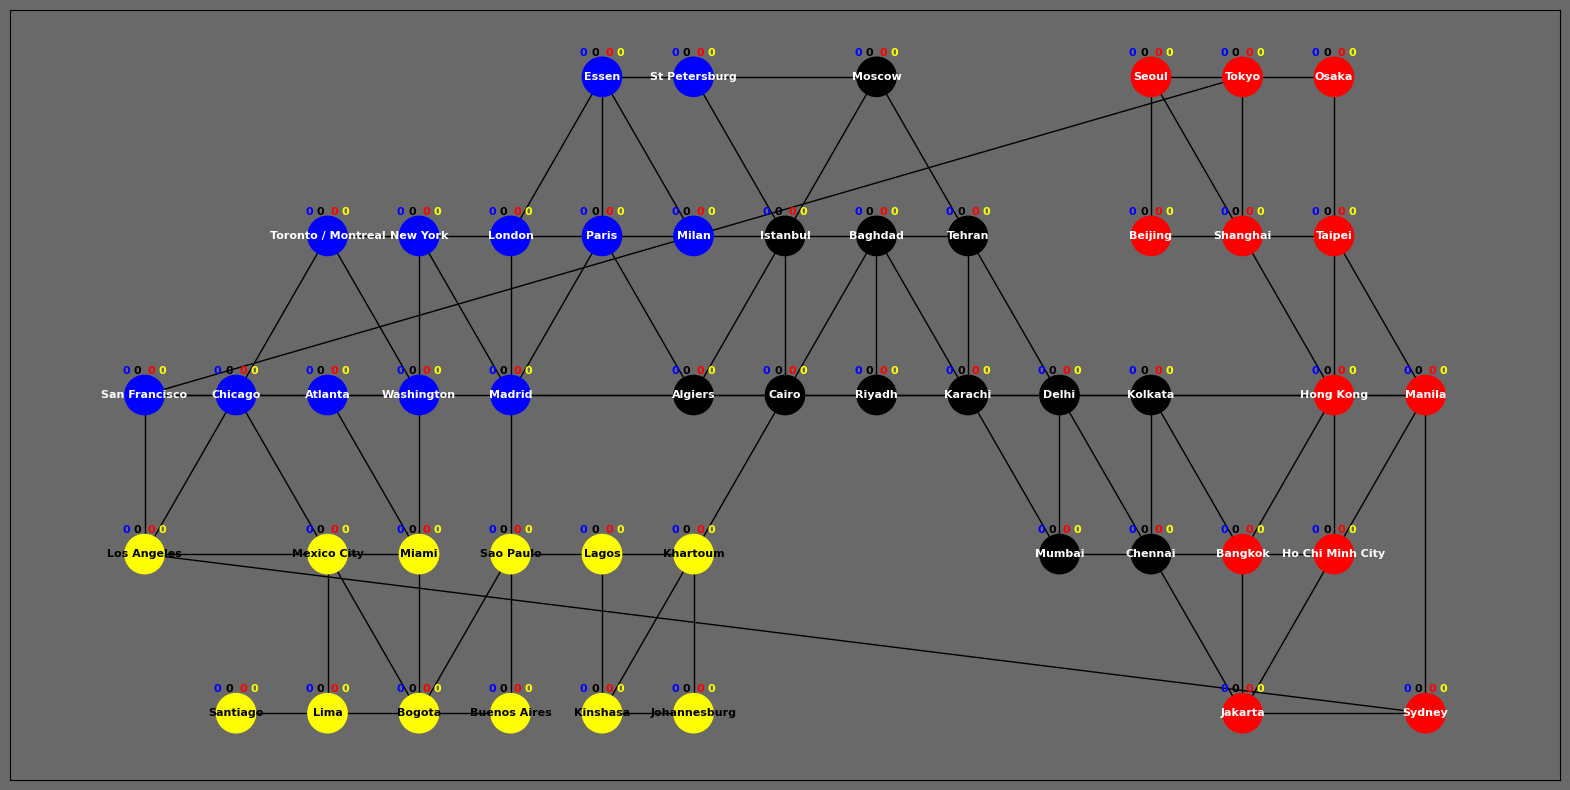

In [5]:
# Create an empty graph
Graph_gameboard = nx.Graph()

# Add nodes with attributes
for city, color in cities_df['Color'].items():
    Graph_gameboard.add_node(city, color=color)

# Add edges from DataFrame
Graph_gameboard.add_edges_from(edges_df.values)

# Set node attributes for disease counters
for city, counters in disease_counters_df.iterrows():
    Graph_gameboard.nodes[city]['disease_counters'] = counters.to_dict()

# Define node positions
node_positions = positions_df.apply(tuple, axis=1).to_dict()

fig, ax = plt.subplots(figsize=(20, 10))

node_colors = [cities_df.loc[city, 'Color'] for city in Graph_gameboard.nodes()]

# change font of nodes with yellow color
yellow_nodes = [city for city, color in cities_df['Color'].items() if color == 'yellow']
font_colors = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

# Draw the nodes
nx.draw_networkx_nodes(Graph_gameboard, pos=node_positions, node_color=node_colors, node_size=800)

# Draw the edges
nx.draw_networkx_edges(Graph_gameboard, pos=node_positions)

# Add labels manually with specified colors
for node, (x, y) in node_positions.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', color=font_colors[node], weight='bold')

ax.set_facecolor('#696969')
fig.set_facecolor('#696969')

font_colors_city_names = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

for node, (x, y) in node_positions.items():
    counters = Graph_gameboard.nodes[node]['disease_counters']

    # Construct labels for each counter with its color
    blue_label = f"{counters['blue']}"
    black_label = f"{counters['black']}"
    red_label = f"{counters['red']}"
    yellow_label = f"{counters['yellow']}"

    # Draw the text for each counter with its color
    plt.text(x - 4, y + 3, blue_label, fontsize=8, ha='center', va='center', color='blue', weight='bold')
    plt.text(x - 1.5, y + 3, black_label, fontsize=8, ha='center', va='center', color='black', weight='bold')
    plt.text(x + 1.5, y + 3, red_label, fontsize=8, ha='center', va='center', color='red', weight='bold')
    plt.text(x + 4, y + 3, yellow_label, fontsize=8, ha='center', va='center', color='yellow', weight='bold')

plt.show()

In [6]:
#@title initialize_pandemic_model
# Initialize the infected cities and the infection_discard_stack, infection_stack, player_stack
def initialize_pandemic_model(graph, strategy, k_action = 4, epidemic_cards = 6, nodes_to_infect_at_start = 3):
    # 96 Cubes 24 in 4 Colors
    # 48 cities
    # 6 Epidemic card
    # Infection rate 7 tiles, (2,2,2,3,3,4,4)
    # Outbreak marker 8 tiles

    # Get and shuffle all Nodes
    num_nodes = graph.number_of_nodes()
    all_nodes = list(graph.nodes)
    random.shuffle(all_nodes)

    # Initialize stacks
    infection_discard_stack = deque()
    infection_stack = deque(all_nodes)
    player_stack = deque()

    # k Nodes to infect at the start (Pandemic normal value is 3x3, 3x2, 3x1 total 9 nodes)
    # Needs to be set to 3 so we do 3 times the different infection counts
    k_nodes_to_infect = nodes_to_infect_at_start

    # Set the amount of epidemic cards (4,5,6 Pandemic)
    epidemics = epidemic_cards

    infection_rate = [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = 0
    outbreak_counter = 0

    k_actions = k_action

    # Set the disinfection strategy
    disinfection_strategy = strategy

    # -------------------------------
    # Start of Epidemic Cards Setup
    # -------------------------------
    if not epidemics == 0:

        # Calculate the chunk size for the epidemics (Floor division)
        chunk_size = num_nodes // epidemics

        # Add chunks with one epidemic node to the player deck
        for i in range(epidemics):
            if i == epidemics - 1:
                chunk = random.sample(all_nodes, len(all_nodes))
            else:
                chunk = random.sample(all_nodes, chunk_size)

            chunk.extend(["Epidemic"])
            random.shuffle(chunk)
            player_stack.extend(chunk)

            # Remove nodes used in this chunk
            all_nodes = list(set(all_nodes) - set(chunk))
    else:
        chunk = random.sample(all_nodes, len(all_nodes))
        random.shuffle(chunk)
        player_stack.extend(chunk)

    #while (epidemics == 1 or epidemics == 2) and player_stack[-1] == "Epidemic":
        #random.shuffle(player_stack)

    # Shuffle the deque in-place
    #random.shuffle(player_stack)
    # -------------------------------
    # End of Epidemic Cards Setup
    # -------------------------------

    # -------------------------------
    # Start of Node infection
    # -------------------------------

    # Infect k nodes with 3 disease counters (blue)
    for node in infection_stack:
        for color in colors:
            graph.nodes[node]["disease_counters"][color] = 0

    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        node_color = graph.nodes[node]['color']
        graph.nodes[node]["disease_counters"][node_color] = 3
        infection_discard_stack.append(node)

    # Infect k nodes with 2 disease counters
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        node_color = graph.nodes[node]['color']
        graph.nodes[node]["disease_counters"][node_color] = 2
        infection_discard_stack.append(node)

    # Infect k nodes with 1 disease counter
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        node_color = graph.nodes[node]['color']
        graph.nodes[node]["disease_counters"][node_color] = 1
        infection_discard_stack.append(node)

    # -------------------------------
    # End of Node infection
    # -------------------------------

    # Set node attributes
    #nx.set_node_attributes(graph, 0, "disease_counters")

    # Initialize the sisr_model
    pandemic_model = {"graph": graph,
                      "infection_stack": infection_stack,
                      "infection_discard_stack": infection_discard_stack,
                      "player_stack": player_stack,
                      "infection_rate": infection_rate,
                      "infection_rate_counter": infection_rate_counter,
                      "outbreak_counter": outbreak_counter,
                      "disinfection_strategy": disinfection_strategy,
                      "k_actions": k_actions,
                      "epidemic_cards": epidemics,
                      "nodes_to_infect_at_start": nodes_to_infect_at_start}

    return pandemic_model

In [7]:
#@title Outbreak
# Outbreak logi
def outbreak(graph, node, color, outbreak_nodes=None, outbreak_counter=0):

    # Set of Nodes that had an Outbreak (1 Outbreak per iteration)
    if outbreak_nodes is None:
        outbreak_nodes = set()  # Initialize the set of nodes that have had an outbreak
    outbreak_nodes.add(node)  # Add the current node to the set

    connected_nodes = graph.neighbors(node)
    #print(connected_nodes)

    # Infect every neighbour
    for cn in connected_nodes:
        if cn not in outbreak_nodes:  # Only process the node if it hasn't had an outbreak yet
            if(graph.nodes[cn]['disease_counters'][color] == 3):
                outbreak(graph, cn, color, outbreak_nodes, outbreak_counter + 1)
            else:
                graph.nodes[cn]['disease_counters'][color] += 1

    return outbreak_counter

In [8]:
#@title Strategy 1: Randomly Disinfect Nodes (one Cube per Node per Turn)
def random_disinfection(graph, k):
    # Randomly disinfect k nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]
    nodes_to_disinfect = random.sample(nodes_to_disinfect, min(k, len(nodes_to_disinfect)))

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        color_to_disinfect = random.choice(colors_to_disinfect)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1

In [ ]:
#@title Strategy 2: Disinfect Nodes with Most Cubes (Nodes can repeat)
def disinfect_most_cubes_repeat(graph, k):
    # Get nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Sort nodes by blue disease counter
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: sum(graph.nodes[node]["disease_counters"].values()), reverse=True)

    # Initialize disinfection count
    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        # Select the node with the most cubes
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        # If the counters become 0, remove the node from the list
        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node:  sum(graph.nodes[node]["disease_counters"].values()), reverse=True)

In [ ]:
#@title Strategy 4: Combination of Most Cubes and Highest Degree (only sort)(repeat)

def disinfect_combined_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: (sum(graph.nodes[node]["disease_counters"].values()), graph.degree[node]), reverse=True)

    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node: (sum(graph.nodes[node]["disease_counters"].values()), graph.degree[node]), reverse=True)

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)

def disinfect_combined_sum(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)(repeat)
def disinfect_combined_sum_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function / Disease counters sum e.g. [3,3,3,3] was before 3 and now it would be 12)

def disinfect_combined_sum_disease_counter_sum(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function / Disease counters sum)(repeat)
def disinfect_combined_sum_disease_counter_sum_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 5: SumCure but the old shit that should be slower DONT USE THIS AND SKIP TO THE NEXT

def disinfect_combined_sum_Cure(graph, k, b, bl, r, y):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))

        # Check if the node color matches with a cured color
        node_color = graph.nodes[node]["color"]
        cure_bonus = 0
        if ((node_color == "blue" and b) or
            (node_color == "black" and bl) or
            (node_color == "red" and r) or
            (node_color == "yellow" and y)):
            cure_bonus = 2  # Add bonus score if the node color matches a cured color

        return degree_score + disease_score + cure_bonus

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:

def disinfect_combined_sum_Cure(graph, k, b, bl, r, y):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))

        # Check if the node color matches with a cured color
        node_color = graph.nodes[node]["color"]
        cure_bonus = 0
        if ((node_color == "blue" and b) or
            (node_color == "black" and bl) or
            (node_color == "red" and r) or
            (node_color == "yellow" and y)):
            cure_bonus = 2  # Add bonus score if the node color matches a cured color

        return degree_score + disease_score + cure_bonus

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]

        cured_colors_to_disinfect = [color for color in colors_to_disinfect if ((color == "blue" and b) or
                                                                                (color == "black" and bl) or
                                                                                (color == "red" and r) or
                                                                                (color == "yellow" and y))]

        # If there are any cured colors to disinfect, prioritize them
        if cured_colors_to_disinfect:
            colors_to_disinfect = cured_colors_to_disinfect

        max_disease_counter = max(graph.nodes[node]["disease_counters"][color] for color in colors_to_disinfect)
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)(repeat)
def disinfect_combined_sum_repeat_Cure(graph, k, b, bl, r, y):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))

        # Check if the node color matches with a cured color
        node_color = graph.nodes[node]["color"]
        cure_bonus = 0
        if ((node_color == "blue" and b) or
            (node_color == "black" and bl) or
            (node_color == "red" and r) or
            (node_color == "yellow" and y)):
            cure_bonus = 2  # Add bonus score if the node color matches a cured color

        return degree_score + disease_score + cure_bonus

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]

        cured_colors_to_disinfect = [color for color in colors_to_disinfect if ((color == "blue" and b) or
                                                                                (color == "black" and bl) or
                                                                                (color == "red" and r) or
                                                                                (color == "yellow" and y))]

        # If there are any cured colors to disinfect, prioritize them
        if cured_colors_to_disinfect:
            colors_to_disinfect = cured_colors_to_disinfect

        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"][color] for color in colors_to_disinfect)
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function / Disease counters sum e.g. [3,3,3,3] was before 3 and now it would be 12)

def disinfect_combined_sum_disease_counter_sum_Cure(graph, k, b, bl, r, y):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        # Check if the node color matches with a cured color
        node_color = graph.nodes[node]["color"]
        cure_bonus = 0
        if ((node_color == "blue" and b) or
            (node_color == "black" and bl) or
            (node_color == "red" and r) or
            (node_color == "yellow" and y)):
            cure_bonus = 2  # Add bonus score if the node color matches a cured color

        return degree_score + disease_score + cure_bonus

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]

        # Check if any of the colors to disinfect have a cure
        cured_colors_to_disinfect = [color for color in colors_to_disinfect if ((color == "blue" and b) or
                                                                                (color == "black" and bl) or
                                                                                (color == "red" and r) or
                                                                                (color == "yellow" and y))]

        # If there are any cured colors to disinfect, prioritize them
        if cured_colors_to_disinfect:
            colors_to_disinfect = cured_colors_to_disinfect

        max_disease_counter = max(graph.nodes[node]["disease_counters"][color] for color in colors_to_disinfect)
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function / Disease counters sum)(repeat)
def disinfect_combined_sum_disease_counter_sum_repeat_Cure(graph, k, b, bl, r, y):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        # Check if the node color matches with a cured color
        node_color = graph.nodes[node]["color"]
        cure_bonus = 0
        if ((node_color == "blue" and b) or
            (node_color == "black" and bl) or
            (node_color == "red" and r) or
            (node_color == "yellow" and y)):
            cure_bonus = 2  # Add bonus score if the node color matches a cured color

        return degree_score + disease_score + cure_bonus

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]

        cured_colors_to_disinfect = [color for color in colors_to_disinfect if ((color == "blue" and b) or
                                                                                (color == "black" and bl) or
                                                                                (color == "red" and r) or
                                                                                (color == "yellow" and y))]

        # If there are any cured colors to disinfect, prioritize them
        if cured_colors_to_disinfect:
            colors_to_disinfect = cured_colors_to_disinfect

        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"][color] for color in colors_to_disinfect)
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1


        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [9]:
def count_susceptible_nodes(graph):
    susceptible_nodes = 0

    for node_data in graph.nodes.values():
        all_colors_zero = all(node_data["disease_counters"][color] == 0 for color in ["blue", "red", "yellow", "black"])
        if all_colors_zero:
            susceptible_nodes += 1

    return susceptible_nodes

In [10]:
def count_nodes_by_infection_level(graph, color):
    infection_nodes = {1: 0, 2: 0, 3: 0}  # Dictionary to count nodes by infection level

    for node_data in graph.nodes.values():
        disease_counter = node_data["disease_counters"][color]
        if disease_counter != 0:
            infection_nodes[disease_counter] += 1

    return infection_nodes

In [11]:
#@title Simulation and CSV creation

def simulate_pandemic(model, num_steps, run):
    graph = model["graph"]  # Get the graph and stacks from the model
    infection_stack = model["infection_stack"]
    infection_discard_stack = model["infection_discard_stack"]
    player_stack = model["player_stack"]
    infection_rate = model["infection_rate"] # [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = model["infection_rate_counter"]
    outbreak_counter = model["outbreak_counter"]
    disinfection_strategy = model["disinfection_strategy"]
    k_actions = model["k_actions"]
    epidemics = model["epidemic_cards"]
    nodes_to_infect_at_start = model["nodes_to_infect_at_start"]

    # Initialize lists to store statistics for each step
    statistics = []
    epidemic_counter = 0
    player_deck_empty  = False

    susceptible_nodes = count_susceptible_nodes(graph)
    infection_nodes_blue = count_nodes_by_infection_level(graph, "blue")
    infection_nodes_black = count_nodes_by_infection_level(graph, "black")
    infection_nodes_red = count_nodes_by_infection_level(graph, "red")
    infection_nodes_yellow = count_nodes_by_infection_level(graph, "yellow")

    cure_blue = False
    cure_red = False
    cure_yellow = False
    cure_black = False

    cure_set_blue = set()
    cure_set_red = set()
    cure_set_yellow = set()
    cure_set_black = set()

    eradicated_blue = False
    eradicated_red = False
    eradicated_yellow = False
    eradicated_black = False

    # Add the init step to the CSV-file
    statistics.append({
        'setup': disinfection_strategy,
        'run': run,  # Index of simulation run
        'k_actions': k_actions,
        'no_epidemic': epidemics,
        'timestep': -1,
        'susceptible_nodes': susceptible_nodes,
        'infected_nodes': infection_nodes_blue[1] + infection_nodes_black[1] + infection_nodes_red[1] + infection_nodes_yellow[1] +
                          infection_nodes_blue[2] + infection_nodes_black[2] + infection_nodes_red[2] + infection_nodes_yellow[2] +
                          infection_nodes_blue[3] + infection_nodes_black[3] + infection_nodes_red[3] + infection_nodes_yellow[3],

        'infection_1_nodes_blue': infection_nodes_blue[1],
        'infection_2_nodes_blue': infection_nodes_blue[2],
        'infection_3_nodes_blue': infection_nodes_blue[3],

        'infection_1_nodes_yellow': infection_nodes_yellow[1],
        'infection_2_nodes_yellow': infection_nodes_yellow[2],
        'infection_3_nodes_yellow': infection_nodes_yellow[3],

        'infection_1_nodes_red': infection_nodes_red[1],
        'infection_2_nodes_red': infection_nodes_red[2],
        'infection_3_nodes_red': infection_nodes_red[3],

        'infection_1_nodes_black': infection_nodes_black[1],
        'infection_2_nodes_black': infection_nodes_black[2],
        'infection_3_nodes_black': infection_nodes_black[3],

        'epidemic_cards_drawn': epidemic_counter,
        'outbreaks': outbreak_counter,
        'deck_empty': player_deck_empty,
        'player_stack': len(player_stack),
        'infection_stack': len(infection_stack),
        'infection_discard_stack': len(infection_discard_stack),
        'infection_rate_counter': infection_rate_counter,

        'cure_blue' : cure_blue,
        'eradicated_blue': False,
        'cure_red': cure_red,
        'eradicated_red': False,
        'cure_yellow': cure_yellow,
        'eradicated_yellow': False,
        'cure_black': cure_black,
        'eradicated_black': False
    })
    for step in range(num_steps):
        if disinfection_strategy == "random":
            random_disinfection(graph, k_actions)
        elif disinfection_strategy == "most_cubes_repeat":
            disinfect_most_cubes_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_repeat":
            disinfect_combined_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_SUM":
            disinfect_combined_sum(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_repeat":
            disinfect_combined_sum_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_DC_sum":
            disinfect_combined_sum_disease_counter_sum(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_DC_sum_repeat":
            disinfect_combined_sum_disease_counter_sum_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_Cure":
            disinfect_combined_sum_Cure(graph, k_actions, cure_blue, cure_black, cure_red, cure_yellow)
        elif disinfection_strategy == "combined_SUM_repeat_Cure":
            disinfect_combined_sum_repeat_Cure(graph, k_actions, cure_blue, cure_black, cure_red, cure_yellow)
        elif disinfection_strategy == "combined_SUM_DC_sum_Cure":
            disinfect_combined_sum_disease_counter_sum_Cure(graph, k_actions, cure_blue, cure_black, cure_red, cure_yellow)
        elif disinfection_strategy == "combined_SUM_DC_sum_repeat_Cure":
            disinfect_combined_sum_disease_counter_sum_repeat_Cure(graph, k_actions, cure_blue, cure_black, cure_red, cure_yellow)
        if cure_blue:
            eradicated_blue = True
            for node_data in graph.nodes.values():
                if node_data["disease_counters"]["blue"] > 0:
                    eradicated_blue = False
                    break
        if cure_red:
            eradicated_red = True
            for node_data in graph.nodes.values():
                if node_data["disease_counters"]["red"] > 0:
                    eradicated_red = False
                    break
        if cure_yellow:
            eradicated_yellow = True
            for node_data in graph.nodes.values():
                if node_data["disease_counters"]["yellow"] > 0:
                    eradicated_yellow = False
                    break
        if cure_black:
            eradicated_black = True
            for node_data in graph.nodes.values():
                if node_data["disease_counters"]["black"] > 0:
                    eradicated_black = False
                    break
        # Draw 2 player stack cards
        for i in range(2):
            # Check if the stack is empty
            if player_stack:

                # Pop the card from the stack that is drawn
                card_player_drawn = player_stack.pop()

                if card_player_drawn in ["Essen", "St Petersburg", "Milan", "Paris", "London", "Madrid", "New York", "Toronto / Montreal", "Washington", "Atlanta", "Chicago", "San Francisco"]:
                    cure_set_blue.add(card_player_drawn)
                    if len(cure_set_blue) == 5:
                        cure_blue = True
                elif card_player_drawn in ["Algiers", "Cairo", "Istanbul", "Moscow", "Baghdad", "Riyadh", "Tehran", "Karachi", "Delhi", "Mumbai", "Kolkata", "Chennai"]:
                    cure_set_black.add(card_player_drawn)
                    if len(cure_set_black) == 5:
                        cure_black = True
                elif card_player_drawn in ["Seoul", "Tokyo", "Osaka", "Beijing", "Shanghai", "Taipei", "Hong Kong", "Manila", "Bangkok", "Jakarta", "Ho Chi Minh City", "Sydney"]:
                    cure_set_red.add(card_player_drawn)
                    if len(cure_set_red) == 5:
                        cure_red = True
                elif card_player_drawn in ["Los Angeles", "Santiago", "Lima", "Mexico City", "Miami", "Bogota", "Sao Paulo", "Buenos Aires", "Lagos", "Kinshasa", "Khartoum", "Johannesburg"]:
                    cure_set_yellow.add(card_player_drawn)
                    if len(cure_set_yellow) == 5:
                        cure_yellow = True

                # Since we don't have a cure we only have the Epidemic logic here
                if card_player_drawn == "Epidemic":
                    # Increment counter for stats
                    epidemic_counter += 1

                    # Infection rate will increase how many nodes get infected each round
                    infection_rate_counter += 1

                    if (infection_stack):
                        # Pop card from the left to simulate a draw from the bottem of the deck
                        node_to_outbreak = infection_stack.popleft()

                        # Add card to the discard stack
                        infection_discard_stack.append(node_to_outbreak)

                        node_to_outbreak_color = graph.nodes[node_to_outbreak]['color']

                        if node_to_outbreak_color == 'blue' and eradicated_blue or node_to_outbreak_color == 'black' and eradicated_black or node_to_outbreak_color == 'red' and eradicated_red or node_to_outbreak_color == 'yellow' and eradicated_yellow:
                            continue
                        # Add 3 cubes to the epidemic node
                        while graph.nodes[node_to_outbreak]["disease_counters"][node_to_outbreak_color] != 3:
                            graph.nodes[node_to_outbreak]["disease_counters"][node_to_outbreak_color] += 1

                        # Call outbereak (increases the node count) and return the outbreak counter for the CSV-File
                        outbreak_counter = outbreak(graph, node_to_outbreak, node_to_outbreak_color, set(node_to_outbreak), outbreak_counter + 1)

                    # Shuffe the discard stack add it on top of the infection stack and delete all nodes from the discard stack
                    random.shuffle(infection_discard_stack)
                    infection_stack.extend(infection_discard_stack)
                    infection_discard_stack.clear()
            else:
                player_deck_empty  = True

        # Draw as many cards as infection rate and infect the cities by 1 cube
        # Game is over if no cards left for the player to draw so we end the infection
        if not player_deck_empty :
            for i in range(infection_rate[infection_rate_counter]):
                if infection_stack:
                    node_to_infect = infection_stack.pop()
                    infection_discard_stack.append(node_to_infect)
                    node_to_infect_color = graph.nodes[node_to_infect]['color']

                    if node_to_infect_color == 'blue' and eradicated_blue or node_to_infect_color == 'black' and eradicated_black or node_to_infect_color == 'red' and eradicated_red or node_to_infect_color == 'yellow' and eradicated_yellow:
                        continue

                    disease_counter = graph.nodes[node_to_infect]["disease_counters"][node_to_infect_color]

                    if disease_counter == 3:
                        outbreak_counter = outbreak(graph, node_to_infect, node_to_infect_color, set(node_to_infect), outbreak_counter + 1)
                    else:
                        graph.nodes[node_to_infect]["disease_counters"][node_to_infect_color] += 1

        # Count node statuses
        susceptible_nodes = count_susceptible_nodes(graph)
        infection_nodes_blue = count_nodes_by_infection_level(graph, "blue")
        infection_nodes_black = count_nodes_by_infection_level(graph, "black")
        infection_nodes_red = count_nodes_by_infection_level(graph, "red")
        infection_nodes_yellow = count_nodes_by_infection_level(graph, "yellow")

        outbreaks = outbreak_counter

        # Append statistics for this time step
        statistics.append({
            'setup': disinfection_strategy,
            'run': run,  # Index of simulation run
            'k_actions': k_actions,
            'no_epidemic': epidemics,
            'timestep': step,
            'susceptible_nodes': susceptible_nodes,
            'infected_nodes': infection_nodes_blue[1] + infection_nodes_black[1] + infection_nodes_red[1] + infection_nodes_yellow[1] +
                              infection_nodes_blue[2] + infection_nodes_black[2] + infection_nodes_red[2] + infection_nodes_yellow[2] +
                              infection_nodes_blue[3] + infection_nodes_black[3] + infection_nodes_red[3] + infection_nodes_yellow[3],

            'infection_1_nodes_blue': infection_nodes_blue[1],
            'infection_2_nodes_blue': infection_nodes_blue[2],
            'infection_3_nodes_blue': infection_nodes_blue[3],

            'infection_1_nodes_yellow': infection_nodes_yellow[1],
            'infection_2_nodes_yellow': infection_nodes_yellow[2],
            'infection_3_nodes_yellow': infection_nodes_yellow[3],

            'infection_1_nodes_red': infection_nodes_red[1],
            'infection_2_nodes_red': infection_nodes_red[2],
            'infection_3_nodes_red': infection_nodes_red[3],

            'infection_1_nodes_black': infection_nodes_black[1],
            'infection_2_nodes_black': infection_nodes_black[2],
            'infection_3_nodes_black': infection_nodes_black[3],
            'epidemic_cards_drawn': epidemic_counter,
            'outbreaks': outbreaks,
            'deck_empty': player_deck_empty,
            'player_stack': len(player_stack),
            'infection_stack': len(infection_stack),
            'infection_discard_stack': len(infection_discard_stack),
            'infection_rate_counter': infection_rate_counter,

            'cure_blue' : cure_blue,
            'eradicated_blue': eradicated_blue,
            'cure_red': cure_red,
            'eradicated_red': eradicated_red,
            'cure_yellow': cure_yellow,
            'eradicated_yellow': eradicated_yellow,
            'cure_black': cure_black,
            'eradicated_black': eradicated_black
        })

    return statistics

In [ ]:
strategies = ["random", "most_cubes_repeat", "combined_repeat",
              "combined_SUM", "combined_SUM_repeat",
              "combined_SUM_DC_sum", "combined_SUM_DC_sum_repeat",
              "combined_SUM_Cure", "combined_SUM_repeat_Cure",
              "combined_SUM_DC_sum_Cure", "combined_SUM_DC_sum_repeat_Cure"]

num_simulations = 10000

k_actions_range = range(9)

epidemic_cards = [0,1,2,3,4,5,6]


In [12]:
strategies = ["random"]

num_simulations = 10000

k_actions_range = range(9)

epidemic_cards = [0,1,2,3,4,5,6]


In [13]:
for strategy in strategies:
    run = 1

    for k_action in k_actions_range[1:]:  # Exclude the baseline k_action
        # Iterate over epidemic cards
        for epidemic in epidemic_cards:
            with open(f'{strategy}2.0_Cure.csv', 'a') as f:
                for num_simulation in range(num_simulations):
                    model = initialize_pandemic_model(Graph_gameboard, strategy, k_action, epidemic, 3)
                    num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                    stats = simulate_pandemic(model, num_steps, run)
                    df = pd.DataFrame(stats)
                    df.to_csv(f, header=not f.tell(), index=False)  # Write DataFrame to file without header if file exists
                    run += 1